In [1]:
# pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


### Basic imports

In [1]:
from skimage.draw import circle_perimeter_aa
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

/u/v/a/vaishnavi_b/Desktop/Circle-Detection-ML-Challenge-/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
from torch.utils.data import DataLoader, TensorDataset
from timeit import default_timer as timer
from src.model import CNNModel
from src.train import *
from src.utils import *
from src.prepare_data import *

In [3]:
# from prepare_data import generate_data, get_train_test_data


# data = generate_data(noise_level=0.1, img_size=100, num_samples=20000)

### Data Preparation and Visualization

In [4]:
train_loader, test_loader = get_train_test_data(noise_level=0.1, img_size=100, num_samples=20000)

../data/noise_0.1_size_100_samples_20000.pkl
Using parameters: noise_level=0.1, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
Data saved to ../data/noise_0.1_size_100_samples_20000.pkl


/afs/cs.wisc.edu/u/v/a/vaishnavi_b/Desktop/Circle-Detection-ML-Challenge-/src/prepare_data.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X_train = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)


DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x7feaa2808e80>, <torch.utils.data.dataloader.DataLoader object at 0x7feb7682ca90>)
Length of train data loader: 500 batches of 32
Length of test data loader: 125 batches of 32


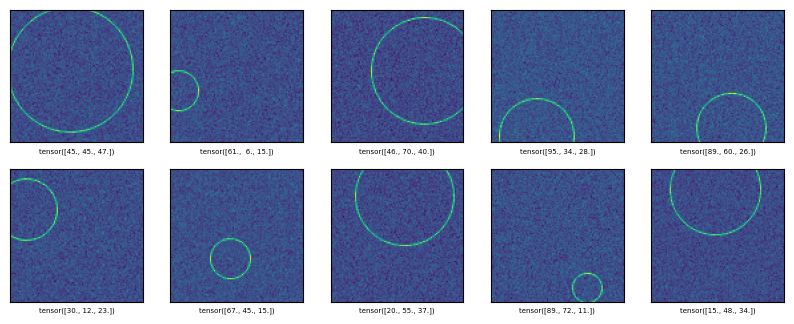

In [5]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    train_features_batch, train_labels_batch = next(iter(train_loader))
    plt.imshow(train_features_batch[i].squeeze())
    plt.xlabel(train_labels_batch[i], fontsize = 5)

### CNN Model Architecture

In [7]:
import torch.nn.functional as F
from torch import nn


class m1(nn.Module):
    def __init__(self, input_shape=1, hidden_units=64, output_shape=3, img_size=100):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1, stride=1), # [1, 64]
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1), #[64, 128]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*4, kernel_size=3, padding=1, stride=1),#[128, 256]
            nn.ReLU(),
            # nn.Conv2d(in_channels=hidden_units*4, out_channels=hidden_units*4, kernel_size=3, stride=1, padding=1),#[256, 256]
            # nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out_layer = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=hidden_units*4*25*25, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        # # print(x.shape)
        x = self.conv_block2(x)
        # # print(x.shape)
        x = self.out_layer(x)
        # print(x.shape)
        return x

### Model, Loss function and Optimizer Initialization

In [8]:

# cuda.empty_cache()


model = m1().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.0001)

### Model Training

In [9]:
# %%capture captured_output

# %store captured_output
torch.manual_seed(42)
start_time= timer()
# print("Hi")
epochs = 50
train_losses = []
test_losses = []
test_accs = []
epochs_ = []

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------", flush = True)
    train_loss, train_acc = train_step(model = model,
               data_loader=train_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               calculate_accuracy=calculate_accuracy,
               device=device
               )

    test_loss, test_acc = test_step(model = model,
               data_loader=test_loader,
               loss_fn=loss_fn,
               calculate_accuracy=calculate_accuracy,
               device=device
               )

    epochs_.append(epoch)
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    test_accs.append(test_acc)





    # Calculate training time
    end_time = timer()
    total_train_time_model = print_train_time(start=start_time,
                                                end=end_time,
                                                device=str(next(model.parameters()).device))
# print(captured_output)


Hi


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
--------
cuda
Train Loss:  358.78406 | Train Accuracy: 0.07
Test Loss:  119.10808 | Test Accuracy: 0.15


  2%|▏         | 1/50 [00:20<16:21, 20.04s/it]

Train time on cuda:0: 20.040 seconds
Epoch: 1
--------
cuda
Train Loss:  94.41418 | Train Accuracy: 0.19
Test Loss:  64.03234 | Test Accuracy: 0.24


  4%|▍         | 2/50 [00:37<15:01, 18.79s/it]

Train time on cuda:0: 37.955 seconds
Epoch: 2
--------
cuda
Train Loss:  43.01305 | Train Accuracy: 0.36
Test Loss:  30.74227 | Test Accuracy: 0.45


  6%|▌         | 3/50 [00:55<14:19, 18.30s/it]

Train time on cuda:0: 55.665 seconds
Epoch: 3
--------
cuda
Train Loss:  25.18588 | Train Accuracy: 0.53
Test Loss:  20.59764 | Test Accuracy: 0.61


  8%|▊         | 4/50 [01:13<13:54, 18.15s/it]

Train time on cuda:0: 73.585 seconds
Epoch: 4
--------
cuda
Train Loss:  18.06458 | Train Accuracy: 0.65
Test Loss:  20.24323 | Test Accuracy: 0.63


 10%|█         | 5/50 [01:31<13:29, 17.98s/it]

Train time on cuda:0: 91.274 seconds
Epoch: 5
--------
cuda
Train Loss:  14.50623 | Train Accuracy: 0.71
Test Loss:  13.56233 | Test Accuracy: 0.73


 12%|█▏        | 6/50 [01:49<13:10, 17.97s/it]

Train time on cuda:0: 109.214 seconds
Epoch: 6
--------
cuda
Train Loss:  12.08495 | Train Accuracy: 0.75
Test Loss:  11.89585 | Test Accuracy: 0.74


 14%|█▍        | 7/50 [02:07<12:51, 17.94s/it]

Train time on cuda:0: 127.109 seconds
Epoch: 7
--------
cuda
Train Loss:  10.24010 | Train Accuracy: 0.79
Test Loss:  12.23415 | Test Accuracy: 0.76


 16%|█▌        | 8/50 [02:24<12:32, 17.92s/it]

Train time on cuda:0: 144.986 seconds
Epoch: 8
--------
cuda
Train Loss:  8.96551 | Train Accuracy: 0.81
Test Loss:  8.73662 | Test Accuracy: 0.81


 18%|█▊        | 9/50 [02:42<12:14, 17.91s/it]

Train time on cuda:0: 162.874 seconds
Epoch: 9
--------
cuda
Train Loss:  7.56908 | Train Accuracy: 0.84
Test Loss:  7.73568 | Test Accuracy: 0.83


 20%|██        | 10/50 [03:00<11:57, 17.94s/it]

Train time on cuda:0: 180.874 seconds
Epoch: 10
--------
cuda
Train Loss:  6.53118 | Train Accuracy: 0.86
Test Loss:  7.11408 | Test Accuracy: 0.86


 22%|██▏       | 11/50 [03:18<11:38, 17.92s/it]

Train time on cuda:0: 198.758 seconds
Epoch: 11
--------
cuda
Train Loss:  5.89468 | Train Accuracy: 0.87
Test Loss:  6.54575 | Test Accuracy: 0.87


 24%|██▍       | 12/50 [03:36<11:20, 17.90s/it]

Train time on cuda:0: 216.621 seconds
Epoch: 12
--------
cuda
Train Loss:  5.05331 | Train Accuracy: 0.89
Test Loss:  5.53750 | Test Accuracy: 0.87


 26%|██▌       | 13/50 [03:54<11:01, 17.88s/it]

Train time on cuda:0: 234.446 seconds
Epoch: 13
--------
cuda
Train Loss:  4.42606 | Train Accuracy: 0.90
Test Loss:  5.89246 | Test Accuracy: 0.87


 28%|██▊       | 14/50 [04:12<10:43, 17.88s/it]

Train time on cuda:0: 252.324 seconds
Epoch: 14
--------
cuda
Train Loss:  4.18151 | Train Accuracy: 0.91
Test Loss:  4.70782 | Test Accuracy: 0.90


 30%|███       | 15/50 [04:30<10:25, 17.87s/it]

Train time on cuda:0: 270.171 seconds
Epoch: 15
--------
cuda
Train Loss:  3.60838 | Train Accuracy: 0.92
Test Loss:  4.93504 | Test Accuracy: 0.86


 32%|███▏      | 16/50 [04:48<10:07, 17.86s/it]

Train time on cuda:0: 288.009 seconds
Epoch: 16
--------
cuda
Train Loss:  3.18714 | Train Accuracy: 0.93
Test Loss:  4.84437 | Test Accuracy: 0.88


 34%|███▍      | 17/50 [05:05<09:49, 17.87s/it]

Train time on cuda:0: 305.914 seconds
Epoch: 17
--------
cuda
Train Loss:  3.05865 | Train Accuracy: 0.93
Test Loss:  3.75207 | Test Accuracy: 0.91


 36%|███▌      | 18/50 [05:23<09:32, 17.88s/it]

Train time on cuda:0: 323.803 seconds
Epoch: 18
--------
cuda
Train Loss:  2.74469 | Train Accuracy: 0.94
Test Loss:  3.91133 | Test Accuracy: 0.90


 38%|███▊      | 19/50 [05:41<09:14, 17.88s/it]

Train time on cuda:0: 341.690 seconds
Epoch: 19
--------
cuda
Train Loss:  2.59209 | Train Accuracy: 0.94
Test Loss:  3.52931 | Test Accuracy: 0.93


 40%|████      | 20/50 [05:59<08:56, 17.89s/it]

Train time on cuda:0: 359.617 seconds
Epoch: 20
--------
cuda
Train Loss:  2.28260 | Train Accuracy: 0.95
Test Loss:  3.11157 | Test Accuracy: 0.94


 42%|████▏     | 21/50 [06:17<08:38, 17.87s/it]

Train time on cuda:0: 377.421 seconds
Epoch: 21
--------
cuda
Train Loss:  2.06293 | Train Accuracy: 0.96
Test Loss:  3.32360 | Test Accuracy: 0.92


 44%|████▍     | 22/50 [06:35<08:21, 17.91s/it]

Train time on cuda:0: 395.424 seconds
Epoch: 22
--------
cuda
Train Loss:  2.00924 | Train Accuracy: 0.96
Test Loss:  2.94151 | Test Accuracy: 0.92


 46%|████▌     | 23/50 [06:53<08:02, 17.88s/it]

Train time on cuda:0: 413.226 seconds
Epoch: 23
--------
cuda
Train Loss:  1.87343 | Train Accuracy: 0.96
Test Loss:  2.82791 | Test Accuracy: 0.94


 48%|████▊     | 24/50 [07:11<07:44, 17.85s/it]

Train time on cuda:0: 431.021 seconds
Epoch: 24
--------
cuda
Train Loss:  1.70878 | Train Accuracy: 0.97
Test Loss:  2.89739 | Test Accuracy: 0.94


 50%|█████     | 25/50 [07:28<07:25, 17.83s/it]

Train time on cuda:0: 448.787 seconds
Epoch: 25
--------
cuda
Train Loss:  1.57214 | Train Accuracy: 0.97
Test Loss:  2.49946 | Test Accuracy: 0.94


 52%|█████▏    | 26/50 [07:46<07:09, 17.90s/it]

Train time on cuda:0: 466.871 seconds
Epoch: 26
--------
cuda
Train Loss:  1.51859 | Train Accuracy: 0.97
Test Loss:  2.51499 | Test Accuracy: 0.93


 54%|█████▍    | 27/50 [08:04<06:51, 17.89s/it]

Train time on cuda:0: 484.718 seconds
Epoch: 27
--------
cuda
Train Loss:  1.46502 | Train Accuracy: 0.97
Test Loss:  2.26956 | Test Accuracy: 0.95


 56%|█████▌    | 28/50 [08:22<06:33, 17.88s/it]

Train time on cuda:0: 502.588 seconds
Epoch: 28
--------
cuda
Train Loss:  1.35282 | Train Accuracy: 0.98
Test Loss:  2.22220 | Test Accuracy: 0.96


 58%|█████▊    | 29/50 [08:40<06:15, 17.89s/it]

Train time on cuda:0: 520.493 seconds
Epoch: 29
--------
cuda
Train Loss:  1.20621 | Train Accuracy: 0.98
Test Loss:  2.27749 | Test Accuracy: 0.96


 60%|██████    | 30/50 [08:58<05:57, 17.89s/it]

Train time on cuda:0: 538.397 seconds
Epoch: 30
--------
cuda
Train Loss:  1.28750 | Train Accuracy: 0.98
Test Loss:  2.27095 | Test Accuracy: 0.94


 62%|██████▏   | 31/50 [09:16<05:39, 17.89s/it]

Train time on cuda:0: 556.265 seconds
Epoch: 31
--------
cuda
Train Loss:  1.08559 | Train Accuracy: 0.98
Test Loss:  2.01041 | Test Accuracy: 0.96


 64%|██████▍   | 32/50 [09:34<05:22, 17.89s/it]

Train time on cuda:0: 574.166 seconds
Epoch: 32
--------
cuda
Train Loss:  1.06589 | Train Accuracy: 0.98
Test Loss:  2.02253 | Test Accuracy: 0.96


 66%|██████▌   | 33/50 [09:52<05:04, 17.88s/it]

Train time on cuda:0: 592.033 seconds
Epoch: 33
--------
cuda
Train Loss:  1.00553 | Train Accuracy: 0.99
Test Loss:  2.70018 | Test Accuracy: 0.96


 68%|██████▊   | 34/50 [10:09<04:46, 17.88s/it]

Train time on cuda:0: 609.910 seconds
Epoch: 34
--------
cuda
Train Loss:  0.97976 | Train Accuracy: 0.99
Test Loss:  1.93756 | Test Accuracy: 0.96


 70%|███████   | 35/50 [10:27<04:28, 17.87s/it]

Train time on cuda:0: 627.769 seconds
Epoch: 35
--------
cuda
Train Loss:  0.90192 | Train Accuracy: 0.99
Test Loss:  1.85808 | Test Accuracy: 0.96


 72%|███████▏  | 36/50 [10:45<04:10, 17.87s/it]

Train time on cuda:0: 645.628 seconds
Epoch: 36
--------
cuda
Train Loss:  0.89664 | Train Accuracy: 0.99
Test Loss:  1.94725 | Test Accuracy: 0.95


 74%|███████▍  | 37/50 [11:03<03:52, 17.87s/it]

Train time on cuda:0: 663.485 seconds
Epoch: 37
--------
cuda
Train Loss:  0.84912 | Train Accuracy: 0.99
Test Loss:  2.21304 | Test Accuracy: 0.97


 76%|███████▌  | 38/50 [11:21<03:34, 17.87s/it]

Train time on cuda:0: 681.377 seconds
Epoch: 38
--------
cuda
Train Loss:  0.88313 | Train Accuracy: 0.99
Test Loss:  1.83834 | Test Accuracy: 0.97


 78%|███████▊  | 39/50 [11:39<03:16, 17.87s/it]

Train time on cuda:0: 699.242 seconds
Epoch: 39
--------
cuda
Train Loss:  0.76301 | Train Accuracy: 0.99
Test Loss:  1.89473 | Test Accuracy: 0.96


 80%|████████  | 40/50 [11:57<02:58, 17.86s/it]

Train time on cuda:0: 717.092 seconds
Epoch: 40
--------
cuda
Train Loss:  0.72321 | Train Accuracy: 0.99
Test Loss:  1.90980 | Test Accuracy: 0.96


 82%|████████▏ | 41/50 [12:14<02:40, 17.87s/it]

Train time on cuda:0: 734.990 seconds
Epoch: 41
--------
cuda
Train Loss:  0.67216 | Train Accuracy: 0.99
Test Loss:  1.72937 | Test Accuracy: 0.97


 84%|████████▍ | 42/50 [12:33<02:25, 18.21s/it]

Train time on cuda:0: 753.995 seconds
Epoch: 42
--------
cuda
Train Loss:  0.65887 | Train Accuracy: 0.99
Test Loss:  1.66412 | Test Accuracy: 0.97


 86%|████████▌ | 43/50 [12:51<02:06, 18.14s/it]

Train time on cuda:0: 771.966 seconds
Epoch: 43
--------
cuda
Train Loss:  0.63673 | Train Accuracy: 0.99
Test Loss:  1.72648 | Test Accuracy: 0.97


 88%|████████▊ | 44/50 [13:09<01:48, 18.05s/it]

Train time on cuda:0: 789.799 seconds
Epoch: 44
--------
cuda
Train Loss:  0.61457 | Train Accuracy: 0.99
Test Loss:  1.68199 | Test Accuracy: 0.96


 90%|█████████ | 45/50 [13:27<01:29, 17.98s/it]

Train time on cuda:0: 807.617 seconds
Epoch: 45
--------
cuda
Train Loss:  0.60562 | Train Accuracy: 0.99
Test Loss:  1.81523 | Test Accuracy: 0.95


 92%|█████████▏| 46/50 [13:45<01:11, 17.99s/it]

Train time on cuda:0: 825.624 seconds
Epoch: 46
--------
cuda
Train Loss:  0.55135 | Train Accuracy: 1.00
Test Loss:  1.57289 | Test Accuracy: 0.97


 94%|█████████▍| 47/50 [14:03<00:53, 17.96s/it]

Train time on cuda:0: 843.506 seconds
Epoch: 47
--------
cuda
Train Loss:  0.54974 | Train Accuracy: 1.00
Test Loss:  1.61726 | Test Accuracy: 0.96


 96%|█████████▌| 48/50 [14:21<00:35, 17.93s/it]

Train time on cuda:0: 861.369 seconds
Epoch: 48
--------
cuda
Train Loss:  0.54931 | Train Accuracy: 1.00
Test Loss:  1.79149 | Test Accuracy: 0.97


 98%|█████████▊| 49/50 [14:39<00:17, 17.90s/it]

Train time on cuda:0: 879.218 seconds
Epoch: 49
--------
cuda
Train Loss:  0.52107 | Train Accuracy: 0.99
Test Loss:  1.59670 | Test Accuracy: 0.97


100%|██████████| 50/50 [14:57<00:00, 17.94s/it]

Train time on cuda:0: 897.106 seconds


### Model Performance Evaluation

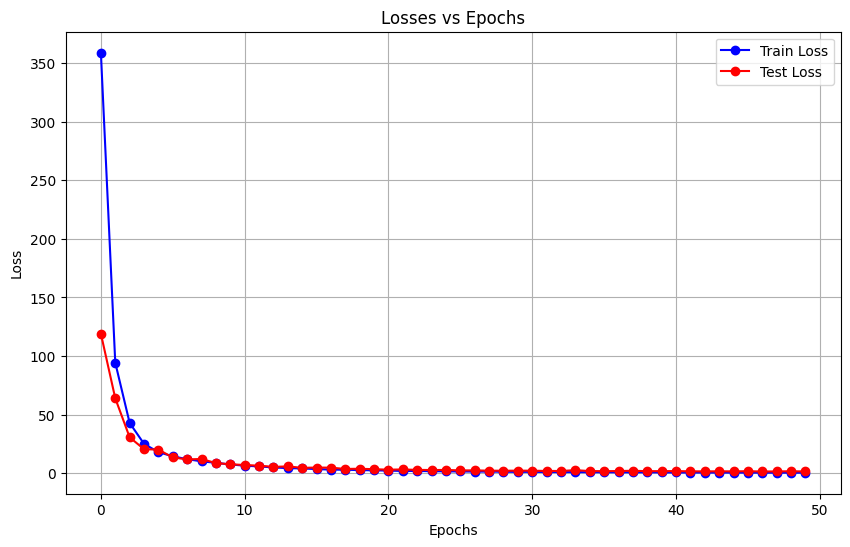

In [11]:

from utils import *
plot_losses(epochs_, train_losses, test_losses)


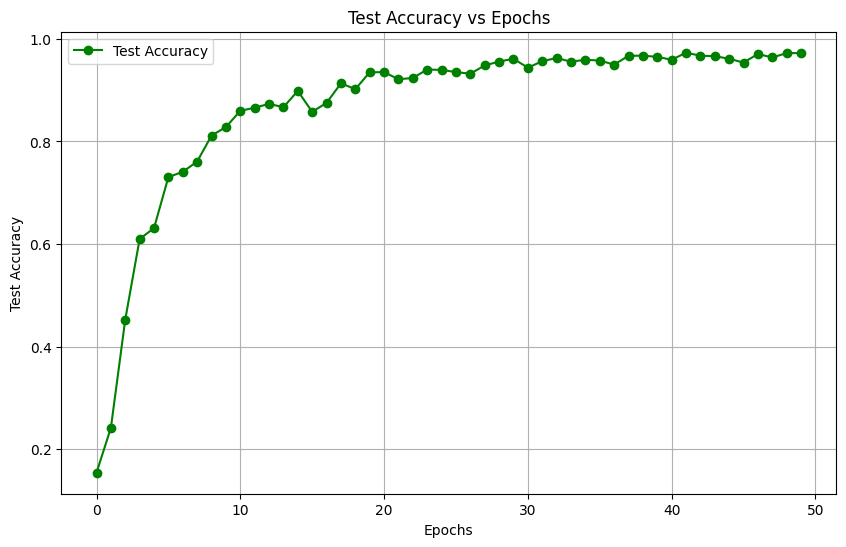

In [12]:

plot_accuracy(epochs_, test_accs)


### Extras

#### Using run.py to run model for noise level as 0.1

In [7]:
from run import *


/u/v/a/vaishnavi_b/Desktop/Circle-Detection-ML-Challenge-/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
epochs_, train_losses, test_losses, test_accs, training_time = run(noise_level=0.1, img_size=100, num_samples=20000, epochs=50)


../data/noise_0.1_size_100_samples_20000.pkl
Using parameters: noise_level=0.1, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
Data saved to ../data/noise_0.1_size_100_samples_20000.pkl
DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x7fe3f300a620>, <torch.utils.data.dataloader.DataLoader object at 0x7fe3f3009ba0>)
Length of train data loader: 500 batches of 32
Length of test data loader: 125 batches of 32
Training started.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
--------
cuda
Train Loss:  337.33521 | Train Accuracy: 0.08
Test Loss:  123.27861 | Test Accuracy: 0.15


  2%|▏         | 1/50 [00:21<17:19, 21.22s/it]

Epoch: 1
--------
cuda
Train Loss:  82.17588 | Train Accuracy: 0.24
Test Loss:  48.21182 | Test Accuracy: 0.35


  4%|▍         | 2/50 [00:40<16:05, 20.11s/it]

Epoch: 2
--------
cuda
Train Loss:  30.46929 | Train Accuracy: 0.47
Test Loss:  20.35859 | Test Accuracy: 0.57


  6%|▌         | 3/50 [00:59<15:29, 19.77s/it]

Epoch: 3
--------
cuda
Train Loss:  16.07109 | Train Accuracy: 0.66
Test Loss:  13.41840 | Test Accuracy: 0.72


  8%|▊         | 4/50 [01:19<15:02, 19.62s/it]

Epoch: 4
--------
cuda
Train Loss:  11.87955 | Train Accuracy: 0.74
Test Loss:  10.90878 | Test Accuracy: 0.75


 10%|█         | 5/50 [01:38<14:41, 19.58s/it]

Epoch: 5
--------
cuda
Train Loss:  9.79118 | Train Accuracy: 0.78
Test Loss:  10.64754 | Test Accuracy: 0.75


 12%|█▏        | 6/50 [01:58<14:19, 19.54s/it]

Epoch: 6
--------
cuda
Train Loss:  8.56002 | Train Accuracy: 0.81
Test Loss:  8.58046 | Test Accuracy: 0.82


 14%|█▍        | 7/50 [02:17<13:58, 19.50s/it]

Epoch: 7
--------
cuda
Train Loss:  7.28496 | Train Accuracy: 0.83
Test Loss:  7.33683 | Test Accuracy: 0.83


 16%|█▌        | 8/50 [02:37<13:38, 19.48s/it]

Epoch: 8
--------
cuda
Train Loss:  6.31789 | Train Accuracy: 0.86
Test Loss:  6.48617 | Test Accuracy: 0.85


 18%|█▊        | 9/50 [02:56<13:18, 19.48s/it]

Epoch: 9
--------
cuda
Train Loss:  5.74648 | Train Accuracy: 0.87
Test Loss:  5.56991 | Test Accuracy: 0.88


 20%|██        | 10/50 [03:16<13:00, 19.51s/it]

Epoch: 10
--------
cuda
Train Loss:  5.28422 | Train Accuracy: 0.88
Test Loss:  4.93829 | Test Accuracy: 0.88


 22%|██▏       | 11/50 [03:35<12:40, 19.50s/it]

Epoch: 11
--------
cuda
Train Loss:  4.62810 | Train Accuracy: 0.89
Test Loss:  4.60949 | Test Accuracy: 0.88


 24%|██▍       | 12/50 [03:55<12:20, 19.48s/it]

Epoch: 12
--------
cuda
Train Loss:  4.13763 | Train Accuracy: 0.91
Test Loss:  4.98797 | Test Accuracy: 0.91


 26%|██▌       | 13/50 [04:14<12:00, 19.47s/it]

Epoch: 13
--------
cuda
Train Loss:  3.67844 | Train Accuracy: 0.92
Test Loss:  4.01189 | Test Accuracy: 0.91


 28%|██▊       | 14/50 [04:34<11:40, 19.47s/it]

Epoch: 14
--------
cuda
Train Loss:  3.32041 | Train Accuracy: 0.93
Test Loss:  3.60298 | Test Accuracy: 0.92


 30%|███       | 15/50 [04:53<11:21, 19.47s/it]

Epoch: 15
--------
cuda
Train Loss:  3.02520 | Train Accuracy: 0.93
Test Loss:  3.44888 | Test Accuracy: 0.91


 32%|███▏      | 16/50 [05:13<11:02, 19.48s/it]

Epoch: 16
--------
cuda
Train Loss:  2.92438 | Train Accuracy: 0.94
Test Loss:  2.97407 | Test Accuracy: 0.93


 34%|███▍      | 17/50 [05:32<10:43, 19.49s/it]

Epoch: 17
--------
cuda
Train Loss:  2.59884 | Train Accuracy: 0.94
Test Loss:  2.85754 | Test Accuracy: 0.94


 36%|███▌      | 18/50 [05:52<10:24, 19.50s/it]

Epoch: 18
--------
cuda
Train Loss:  2.46178 | Train Accuracy: 0.95
Test Loss:  2.72497 | Test Accuracy: 0.93


 38%|███▊      | 19/50 [06:11<10:04, 19.50s/it]

Epoch: 19
--------
cuda
Train Loss:  2.17800 | Train Accuracy: 0.95
Test Loss:  2.54316 | Test Accuracy: 0.94


 40%|████      | 20/50 [06:31<09:45, 19.51s/it]

Epoch: 20
--------
cuda
Train Loss:  2.06761 | Train Accuracy: 0.96
Test Loss:  3.00909 | Test Accuracy: 0.94


 42%|████▏     | 21/50 [06:50<09:25, 19.51s/it]

Epoch: 21
--------
cuda
Train Loss:  1.87478 | Train Accuracy: 0.96
Test Loss:  2.39915 | Test Accuracy: 0.95


 44%|████▍     | 22/50 [07:10<09:06, 19.51s/it]

Epoch: 22
--------
cuda
Train Loss:  1.84394 | Train Accuracy: 0.96
Test Loss:  2.76061 | Test Accuracy: 0.93


 46%|████▌     | 23/50 [07:29<08:47, 19.52s/it]

Epoch: 23
--------
cuda
Train Loss:  1.66751 | Train Accuracy: 0.97
Test Loss:  2.31674 | Test Accuracy: 0.93


 48%|████▊     | 24/50 [07:49<08:27, 19.53s/it]

Epoch: 24
--------
cuda
Train Loss:  1.61156 | Train Accuracy: 0.97
Test Loss:  1.98737 | Test Accuracy: 0.96


 50%|█████     | 25/50 [08:09<08:11, 19.67s/it]

Epoch: 25
--------
cuda
Train Loss:  1.54554 | Train Accuracy: 0.97
Test Loss:  2.10560 | Test Accuracy: 0.95


 52%|█████▏    | 26/50 [08:29<07:53, 19.74s/it]

Epoch: 26
--------
cuda
Train Loss:  1.43578 | Train Accuracy: 0.97
Test Loss:  1.86322 | Test Accuracy: 0.97


 54%|█████▍    | 27/50 [08:48<07:33, 19.71s/it]

Epoch: 27
--------
cuda
Train Loss:  1.32222 | Train Accuracy: 0.98
Test Loss:  1.88961 | Test Accuracy: 0.96


 56%|█████▌    | 28/50 [09:08<07:11, 19.64s/it]

Epoch: 28
--------
cuda
Train Loss:  1.23798 | Train Accuracy: 0.98
Test Loss:  1.62777 | Test Accuracy: 0.96


 58%|█████▊    | 29/50 [09:27<06:51, 19.59s/it]

Epoch: 29
--------
cuda
Train Loss:  1.19137 | Train Accuracy: 0.98
Test Loss:  1.64869 | Test Accuracy: 0.97


 60%|██████    | 30/50 [09:47<06:31, 19.56s/it]

Epoch: 30
--------
cuda
Train Loss:  1.17524 | Train Accuracy: 0.98
Test Loss:  1.64329 | Test Accuracy: 0.97


 62%|██████▏   | 31/50 [10:06<06:11, 19.54s/it]

Epoch: 31
--------
cuda
Train Loss:  1.08691 | Train Accuracy: 0.98
Test Loss:  1.76181 | Test Accuracy: 0.98


 64%|██████▍   | 32/50 [10:26<05:51, 19.53s/it]

Epoch: 32
--------
cuda
Train Loss:  0.99664 | Train Accuracy: 0.98
Test Loss:  1.57495 | Test Accuracy: 0.97


 66%|██████▌   | 33/50 [10:45<05:31, 19.52s/it]

Epoch: 33
--------
cuda
Train Loss:  0.99079 | Train Accuracy: 0.99
Test Loss:  1.52515 | Test Accuracy: 0.97


 68%|██████▊   | 34/50 [11:05<05:12, 19.52s/it]

Epoch: 34
--------
cuda
Train Loss:  0.91981 | Train Accuracy: 0.99
Test Loss:  1.51457 | Test Accuracy: 0.97


 70%|███████   | 35/50 [11:24<04:52, 19.50s/it]

Epoch: 35
--------
cuda
Train Loss:  0.89881 | Train Accuracy: 0.99
Test Loss:  2.38063 | Test Accuracy: 0.97


 72%|███████▏  | 36/50 [11:44<04:32, 19.49s/it]

Epoch: 36
--------
cuda
Train Loss:  0.86454 | Train Accuracy: 0.99
Test Loss:  1.72296 | Test Accuracy: 0.96


 74%|███████▍  | 37/50 [12:03<04:13, 19.49s/it]

Epoch: 37
--------
cuda
Train Loss:  0.79170 | Train Accuracy: 0.99
Test Loss:  1.33795 | Test Accuracy: 0.98


 76%|███████▌  | 38/50 [12:23<03:53, 19.48s/it]

Epoch: 38
--------
cuda
Train Loss:  0.74942 | Train Accuracy: 0.99
Test Loss:  1.41612 | Test Accuracy: 0.98


 78%|███████▊  | 39/50 [12:42<03:34, 19.47s/it]

Epoch: 39
--------
cuda
Train Loss:  0.78734 | Train Accuracy: 0.99
Test Loss:  1.36490 | Test Accuracy: 0.98


 80%|████████  | 40/50 [13:02<03:14, 19.48s/it]

Epoch: 40
--------
cuda
Train Loss:  0.73953 | Train Accuracy: 0.99
Test Loss:  1.50468 | Test Accuracy: 0.98


 82%|████████▏ | 41/50 [13:21<02:55, 19.48s/it]

Epoch: 41
--------
cuda
Train Loss:  0.67029 | Train Accuracy: 0.99
Test Loss:  1.50385 | Test Accuracy: 0.96


 84%|████████▍ | 42/50 [13:41<02:35, 19.49s/it]

Epoch: 42
--------
cuda
Train Loss:  0.66764 | Train Accuracy: 0.99
Test Loss:  1.25889 | Test Accuracy: 0.98


 86%|████████▌ | 43/50 [14:00<02:16, 19.47s/it]

Epoch: 43
--------
cuda
Train Loss:  0.63788 | Train Accuracy: 0.99
Test Loss:  1.28037 | Test Accuracy: 0.98


 88%|████████▊ | 44/50 [14:19<01:56, 19.46s/it]

Epoch: 44
--------
cuda
Train Loss:  0.57082 | Train Accuracy: 0.99
Test Loss:  1.25917 | Test Accuracy: 0.97


 90%|█████████ | 45/50 [14:39<01:37, 19.47s/it]

Epoch: 45
--------
cuda
Train Loss:  0.62969 | Train Accuracy: 0.99
Test Loss:  1.24424 | Test Accuracy: 0.98


 92%|█████████▏| 46/50 [14:58<01:17, 19.47s/it]

Epoch: 46
--------
cuda
Train Loss:  0.52665 | Train Accuracy: 1.00
Test Loss:  1.35912 | Test Accuracy: 0.98


 94%|█████████▍| 47/50 [15:18<00:58, 19.48s/it]

Epoch: 47
--------
cuda
Train Loss:  0.61989 | Train Accuracy: 0.99
Test Loss:  1.17622 | Test Accuracy: 0.98


 96%|█████████▌| 48/50 [15:37<00:38, 19.46s/it]

Epoch: 48
--------
cuda
Train Loss:  0.47909 | Train Accuracy: 1.00
Test Loss:  1.27535 | Test Accuracy: 0.98


 98%|█████████▊| 49/50 [15:57<00:19, 19.42s/it]

Epoch: 49
--------
cuda
Train Loss:  0.57473 | Train Accuracy: 1.00
Test Loss:  1.12016 | Test Accuracy: 0.98


100%|██████████| 50/50 [16:16<00:00, 19.53s/it]

Train time on cuda:0: 976.361 seconds
Training completed.


Model saved to model_noise_0.1_size_100_samples_20000.pkl


In [8]:
# %%capture captured_output
result = run(noise_level=0.2, img_size=100, num_samples=20000, epochs=50)


../data/noise_0.2_size_100_samples_20000.pkl
Using parameters: noise_level=0.2, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
Data saved to ../data/noise_0.2_size_100_samples_20000.pkl


/afs/cs.wisc.edu/u/v/a/vaishnavi_b/Desktop/Circle-Detection-ML-Challenge-/prepare_data.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X_train = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)


DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x7fec95556b60>, <torch.utils.data.dataloader.DataLoader object at 0x7fec95555c00>)
Length of train data loader: 500 batches of 32
Length of test data loader: 125 batches of 32
Training started.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
--------
cuda
Train Loss:  434.29404 | Train Accuracy: 0.04
Test Loss:  161.61499 | Test Accuracy: 0.10


  2%|▏         | 1/50 [00:17<14:39, 17.95s/it]

Epoch: 1
--------
cuda
Train Loss:  130.23929 | Train Accuracy: 0.13
Test Loss:  99.91148 | Test Accuracy: 0.19


  4%|▍         | 2/50 [00:35<14:14, 17.81s/it]

Epoch: 2
--------
cuda
Train Loss:  66.11334 | Train Accuracy: 0.26
Test Loss:  42.24589 | Test Accuracy: 0.37


  6%|▌         | 3/50 [00:53<13:54, 17.76s/it]

Epoch: 3
--------
cuda
Train Loss:  33.87618 | Train Accuracy: 0.44
Test Loss:  28.38019 | Test Accuracy: 0.51


  8%|▊         | 4/50 [01:11<13:38, 17.79s/it]

Epoch: 4
--------
cuda
Train Loss:  24.36776 | Train Accuracy: 0.56
Test Loss:  23.57922 | Test Accuracy: 0.58


 10%|█         | 5/50 [01:29<13:21, 17.80s/it]

Epoch: 5
--------
cuda
Train Loss:  19.32547 | Train Accuracy: 0.63
Test Loss:  17.99437 | Test Accuracy: 0.66


 12%|█▏        | 6/50 [01:46<13:03, 17.82s/it]

Epoch: 6
--------
cuda
Train Loss:  15.23860 | Train Accuracy: 0.69
Test Loss:  16.80918 | Test Accuracy: 0.67


 14%|█▍        | 7/50 [02:04<12:47, 17.84s/it]

Epoch: 7
--------
cuda
Train Loss:  12.81279 | Train Accuracy: 0.73
Test Loss:  12.71873 | Test Accuracy: 0.75


 16%|█▌        | 8/50 [02:22<12:29, 17.85s/it]

Epoch: 8
--------
cuda
Train Loss:  11.17419 | Train Accuracy: 0.76
Test Loss:  11.06741 | Test Accuracy: 0.76


 18%|█▊        | 9/50 [02:41<12:22, 18.11s/it]

Epoch: 9
--------
cuda
Train Loss:  9.52099 | Train Accuracy: 0.80
Test Loss:  10.47175 | Test Accuracy: 0.79


 20%|██        | 10/50 [03:00<12:13, 18.33s/it]

Epoch: 10
--------
cuda
Train Loss:  8.44886 | Train Accuracy: 0.82
Test Loss:  8.62988 | Test Accuracy: 0.81


 22%|██▏       | 11/50 [03:18<11:56, 18.38s/it]

Epoch: 11
--------
cuda
Train Loss:  7.69416 | Train Accuracy: 0.84
Test Loss:  8.25968 | Test Accuracy: 0.82


 24%|██▍       | 12/50 [03:36<11:35, 18.31s/it]

Epoch: 12
--------
cuda
Train Loss:  6.80153 | Train Accuracy: 0.85
Test Loss:  7.80927 | Test Accuracy: 0.83


 26%|██▌       | 13/50 [03:54<11:12, 18.18s/it]

Epoch: 13
--------
cuda
Train Loss:  6.14802 | Train Accuracy: 0.87
Test Loss:  7.27936 | Test Accuracy: 0.85


 28%|██▊       | 14/50 [04:12<10:51, 18.11s/it]

Epoch: 14
--------
cuda
Train Loss:  5.62750 | Train Accuracy: 0.88
Test Loss:  6.65410 | Test Accuracy: 0.87


 30%|███       | 15/50 [04:30<10:32, 18.07s/it]

Epoch: 15
--------
cuda
Train Loss:  5.14101 | Train Accuracy: 0.89
Test Loss:  7.24406 | Test Accuracy: 0.85


 32%|███▏      | 16/50 [04:48<10:13, 18.04s/it]

Epoch: 16
--------
cuda
Train Loss:  4.62294 | Train Accuracy: 0.90
Test Loss:  5.35501 | Test Accuracy: 0.88


 34%|███▍      | 17/50 [05:06<09:53, 18.00s/it]

Epoch: 17
--------
cuda
Train Loss:  4.26226 | Train Accuracy: 0.91
Test Loss:  5.11161 | Test Accuracy: 0.88


 36%|███▌      | 18/50 [05:24<09:34, 17.96s/it]

Epoch: 18
--------
cuda
Train Loss:  3.96813 | Train Accuracy: 0.91
Test Loss:  4.84316 | Test Accuracy: 0.90


 38%|███▊      | 19/50 [05:42<09:16, 17.96s/it]

Epoch: 19
--------
cuda
Train Loss:  3.58167 | Train Accuracy: 0.92
Test Loss:  4.81880 | Test Accuracy: 0.87


 40%|████      | 20/50 [06:00<08:58, 17.96s/it]

Epoch: 20
--------
cuda
Train Loss:  3.43730 | Train Accuracy: 0.93
Test Loss:  4.35465 | Test Accuracy: 0.90


 42%|████▏     | 21/50 [06:18<08:41, 17.97s/it]

Epoch: 21
--------
cuda
Train Loss:  3.16321 | Train Accuracy: 0.93
Test Loss:  4.12976 | Test Accuracy: 0.92


 44%|████▍     | 22/50 [06:36<08:25, 18.05s/it]

Epoch: 22
--------
cuda
Train Loss:  2.96575 | Train Accuracy: 0.94
Test Loss:  3.99486 | Test Accuracy: 0.91


 46%|████▌     | 23/50 [06:54<08:09, 18.14s/it]

Epoch: 23
--------
cuda
Train Loss:  2.77174 | Train Accuracy: 0.94
Test Loss:  3.78899 | Test Accuracy: 0.91


 48%|████▊     | 24/50 [07:13<07:54, 18.26s/it]

Epoch: 24
--------
cuda
Train Loss:  2.58518 | Train Accuracy: 0.95
Test Loss:  3.74779 | Test Accuracy: 0.92


 50%|█████     | 25/50 [07:31<07:38, 18.35s/it]

Epoch: 25
--------
cuda
Train Loss:  2.40216 | Train Accuracy: 0.95
Test Loss:  3.97231 | Test Accuracy: 0.90


 52%|█████▏    | 26/50 [07:50<07:22, 18.43s/it]

Epoch: 26
--------
cuda
Train Loss:  2.30021 | Train Accuracy: 0.95
Test Loss:  3.81258 | Test Accuracy: 0.90


 54%|█████▍    | 27/50 [08:08<07:02, 18.36s/it]

Epoch: 27
--------
cuda
Train Loss:  2.16739 | Train Accuracy: 0.96
Test Loss:  3.64065 | Test Accuracy: 0.93


 56%|█████▌    | 28/50 [08:26<06:41, 18.26s/it]

Epoch: 28
--------
cuda
Train Loss:  2.00891 | Train Accuracy: 0.96
Test Loss:  3.65162 | Test Accuracy: 0.91


 58%|█████▊    | 29/50 [08:44<06:21, 18.17s/it]

Epoch: 29
--------
cuda
Train Loss:  1.95235 | Train Accuracy: 0.96
Test Loss:  3.22064 | Test Accuracy: 0.92


 60%|██████    | 30/50 [09:02<06:01, 18.09s/it]

Epoch: 30
--------
cuda
Train Loss:  1.70336 | Train Accuracy: 0.97
Test Loss:  3.17895 | Test Accuracy: 0.94


 62%|██████▏   | 31/50 [09:20<05:42, 18.05s/it]

Epoch: 31
--------
cuda
Train Loss:  1.70370 | Train Accuracy: 0.97
Test Loss:  3.22767 | Test Accuracy: 0.94


 64%|██████▍   | 32/50 [09:38<05:24, 18.05s/it]

Epoch: 32
--------
cuda
Train Loss:  1.49900 | Train Accuracy: 0.98
Test Loss:  2.96292 | Test Accuracy: 0.94


 66%|██████▌   | 33/50 [09:56<05:06, 18.02s/it]

Epoch: 33
--------
cuda
Train Loss:  1.42028 | Train Accuracy: 0.98
Test Loss:  2.94543 | Test Accuracy: 0.94


 68%|██████▊   | 34/50 [10:14<04:48, 18.01s/it]

Epoch: 34
--------
cuda
Train Loss:  1.32172 | Train Accuracy: 0.98
Test Loss:  3.04248 | Test Accuracy: 0.93


 70%|███████   | 35/50 [10:32<04:30, 18.01s/it]

Epoch: 35
--------
cuda
Train Loss:  1.23490 | Train Accuracy: 0.98
Test Loss:  2.96702 | Test Accuracy: 0.93


 72%|███████▏  | 36/50 [10:50<04:11, 17.99s/it]

Epoch: 36
--------
cuda
Train Loss:  1.18745 | Train Accuracy: 0.98
Test Loss:  2.89700 | Test Accuracy: 0.94


 74%|███████▍  | 37/50 [11:08<03:53, 17.96s/it]

Epoch: 37
--------
cuda
Train Loss:  1.07704 | Train Accuracy: 0.98
Test Loss:  3.29096 | Test Accuracy: 0.94


 76%|███████▌  | 38/50 [11:26<03:36, 18.03s/it]

Epoch: 38
--------
cuda
Train Loss:  1.06867 | Train Accuracy: 0.99
Test Loss:  2.81098 | Test Accuracy: 0.94


 78%|███████▊  | 39/50 [11:45<03:20, 18.20s/it]

Epoch: 39
--------
cuda
Train Loss:  0.96939 | Train Accuracy: 0.99
Test Loss:  2.85426 | Test Accuracy: 0.94


 80%|████████  | 40/50 [12:03<03:02, 18.28s/it]

Epoch: 40
--------
cuda
Train Loss:  0.98309 | Train Accuracy: 0.99
Test Loss:  2.94602 | Test Accuracy: 0.95


 82%|████████▏ | 41/50 [12:22<02:45, 18.34s/it]

Epoch: 41
--------
cuda
Train Loss:  0.76372 | Train Accuracy: 0.99
Test Loss:  2.74550 | Test Accuracy: 0.94


 84%|████████▍ | 42/50 [12:40<02:26, 18.36s/it]

Epoch: 42
--------
cuda
Train Loss:  0.77171 | Train Accuracy: 0.99
Test Loss:  3.04160 | Test Accuracy: 0.92


 86%|████████▌ | 43/50 [12:58<02:07, 18.26s/it]

Epoch: 43
--------
cuda
Train Loss:  0.74940 | Train Accuracy: 0.99
Test Loss:  2.78992 | Test Accuracy: 0.93


 88%|████████▊ | 44/50 [13:16<01:48, 18.14s/it]

Epoch: 44
--------
cuda
Train Loss:  0.67367 | Train Accuracy: 0.99
Test Loss:  2.68338 | Test Accuracy: 0.94


 90%|█████████ | 45/50 [13:34<01:30, 18.06s/it]

Epoch: 45
--------
cuda
Train Loss:  0.62489 | Train Accuracy: 0.99
Test Loss:  2.66232 | Test Accuracy: 0.94


 92%|█████████▏| 46/50 [13:52<01:12, 18.00s/it]

Epoch: 46
--------
cuda
Train Loss:  0.63297 | Train Accuracy: 0.99
Test Loss:  2.65772 | Test Accuracy: 0.94


 94%|█████████▍| 47/50 [14:10<00:53, 17.96s/it]

Epoch: 47
--------
cuda
Train Loss:  0.56239 | Train Accuracy: 1.00
Test Loss:  2.61066 | Test Accuracy: 0.95


 96%|█████████▌| 48/50 [14:27<00:35, 17.92s/it]

Epoch: 48
--------
cuda
Train Loss:  0.55587 | Train Accuracy: 1.00
Test Loss:  2.74857 | Test Accuracy: 0.95


 98%|█████████▊| 49/50 [14:45<00:17, 17.89s/it]

Epoch: 49
--------
cuda
Train Loss:  0.46245 | Train Accuracy: 1.00
Test Loss:  2.53853 | Test Accuracy: 0.95


100%|██████████| 50/50 [15:03<00:00, 18.07s/it]

Train time on cuda:0: 903.442 seconds
Training completed.


Model saved to model_noise_0.2_size_100_samples_20000.pkl


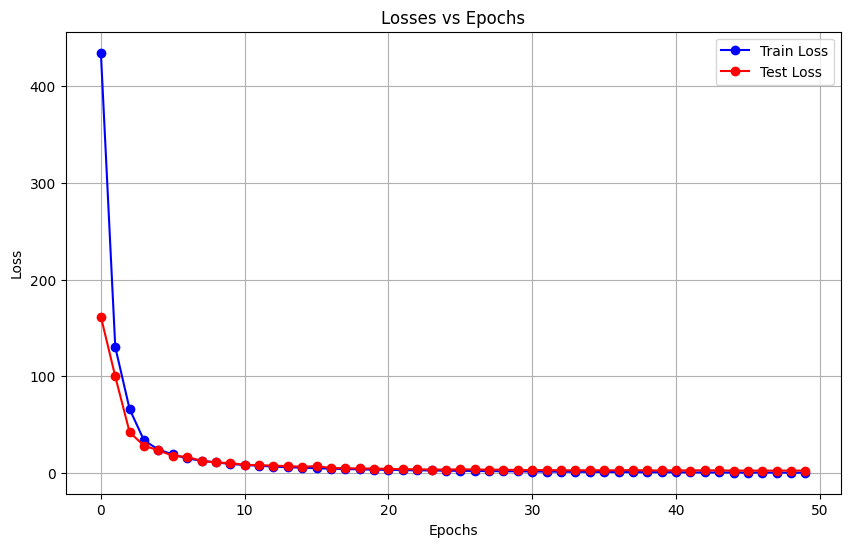

In [13]:
from utils import *

plot_losses(result["epochs"], result["train_losses"], result["test_losses"])



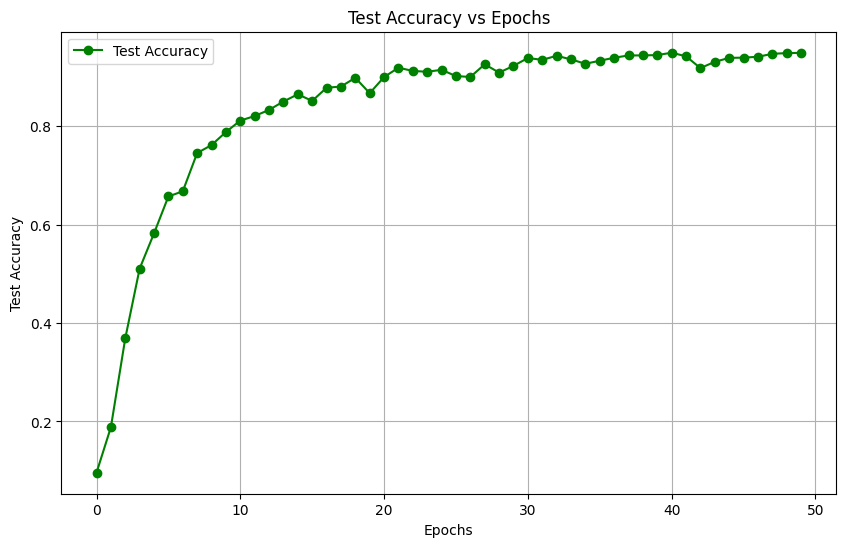

In [14]:
plot_accuracy(result["epochs"], result["test_accs"])


In [ ]:
epochs_03, train_losses_03, test_losses_03, test_accs_03, training_time_03 = run(noise_level=0.3, img_size=100, num_samples=20000, epochs=50)
